In [1]:
import numpy as np
import pandas as pd
import sweetviz as sv
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from geopy.geocoders import Nominatim
from sklearn import preprocessing
from scipy import stats
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
import seaborn as sns

pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 200)
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [2]:
def hot_encode(df):
    for c in df.columns:
        if c=='i9_health':
            df[c].replace('Yes', 1, inplace=True)
            df[c].replace('No', 0, inplace=True)
            df[c].replace('N/A', 2, inplace=True)
            df[c].replace('Not sure', 2, inplace=True)
        else:
        
            if set(df[c].value_counts().index).issubset({'Yes', 'No', 'Not sure', 'N/A'}):
                df[c].replace('Yes', 1, inplace=True)
                df[c].replace('No', 0, inplace=True)

            if set(df[c].value_counts().index).issubset({'Always', 'Not at all', 'Sometimes', 'Frequently', 'Rarely', 'N/A'}):
                df[c].replace('Always', 2, inplace=True)
                df[c].replace('Frequently', 1, inplace=True)
                df[c].replace('Sometimes', 0, inplace=True)
                df[c].replace('Rarely', -1, inplace=True)
                df[c].replace('Not at all', -2, inplace=True)

            if set(df[c].value_counts().index).issubset({'USA', 'CAN'}):
                df[c].replace('USA', 1, inplace=True)
                df[c].replace('CAN', -1, inplace=True)

            if set(df[c].value_counts().index).issubset({'Male', 'Female'}):
                df[c].replace('Male', 1, inplace=True)
                df[c].replace('Female', -1, inplace=True)

            if set(df[c].value_counts().index).issubset({'Yes, and I tested positive', 'Yes, and I have not received my results from the test yet', 'Yes, and I tested negative', 'No, I have not', 'N/A'}):
                df[c].replace('Yes, and I tested positive', -1, inplace=True)
                df[c].replace('Yes, and I have not received my results from the test yet', 0, inplace=True)
                df[c].replace('No, I have not', 0, inplace=True)
                df[c].replace( 'Yes, and I tested negative', 1, inplace=True)

            if set(df[c].value_counts().index).issubset({'Not sure', 'Yes, and they tested positive', 'No, they have not', 'Yes, and they have not received their results from the test yet', 'Yes, and they tested negative', 'N/A'}):
                df[c].replace('Yes, and they tested positive', -1, inplace=True)
                df[c].replace('Yes, and they have not received their results from the test yet', 0, inplace=True)
                df[c].replace('No, they have not', 0, inplace=True)
                df[c].replace('Yes, and they tested negative', 1, inplace=True)

            if set(df[c].value_counts().index).issubset({'Part time employment', 'Not working', 'Unemployed', 'Other', 'Full time employment', 'Full time student', 'Retired'}):
                df[c].replace('Full time employment', 1, inplace=True)
                df[c].replace('Full time student', 1, inplace=True)
                df[c].replace('Part time employment', 0.5, inplace=True)
                df[c].replace('Not working', 0, inplace=True)
                df[c].replace('Unemployed', 0, inplace=True)
                df[c].replace('Other', 0, inplace=True)
                df[c].replace('Retired', 0, inplace=True)

            if set(df[c].value_counts().index).issubset({'Very easy', 'Somewhat difficult', 'Somewhat easy', 'Neither easy nor difficult', 'Very difficult', 'N/A', 'Not sure'}):
                df[c].replace('Very easy', 5, inplace=True)
                df[c].replace('Somewhat difficult', 2, inplace=True)
                df[c].replace('Somewhat easy', 4, inplace=True)
                df[c].replace('Neither easy nor difficult', 3, inplace=True)
                df[c].replace('Very difficult', 1, inplace=True)

            if set(df[c].value_counts().index).issubset({'Very willing', 'Somewhat willing', 'Neither willing nor unwilling', 'Somewhat unwilling', 'Very unwilling', 'N/A', 'Not sure'}):
                df[c].replace('Very willing', 5, inplace=True)
                df[c].replace('Somewhat willing', 4, inplace=True)
                df[c].replace('Neither willing nor unwilling', 3, inplace=True)
                df[c].replace('Somewhat unwilling', 2, inplace=True)
                df[c].replace('Very unwilling', 1, inplace=True)

            df[c].replace('N/A', 0, inplace=True)
            df[c].replace('Not sure', 0, inplace=True)
        
    return df

In [3]:
def combine_columns(df):
    temp_df = df[[c for c in df.columns if c[:3]=="i5_" and c[-3:]!="_99"]]
    df["i5_health_avg"] = temp_df.sum(axis=1)/temp_df.columns.size

    temp_df = df[[c for c in df.columns if c[:4]=="i12_"]]
    df["i12_health_avg"] = temp_df.sum(axis=1)/temp_df.columns.size

    temp_df = df[[c for c in df.columns if c[:3]=="d1_" and c[-3:]!="99"]]
    df["d1_health_avg"] = temp_df.sum(axis=1)/temp_df.columns.size

    temp_df = df[[c for c in ['i10_health', 'i11_health']]]
    df["i10_11_sum"] = temp_df.sum(axis=1)
    df["i10_11_prod"] = temp_df.prod(axis=1)
    
    return df

In [4]:
def get_coordinates(df):
    locs = {}
    geolocator = Nominatim(user_agent='http')
    df["region_state"] = df["region_state"].apply(lambda x: x.split(" / ")[0])

    def loc2coord(loc, geolocator):
        location = geolocator.geocode(loc)
        lat = location.latitude
        lng = location.longitude
        return lat,lng

    for loc in df["region_state"].unique():
        locs[loc] = loc2coord(loc, geolocator)
        
    df['lat'] = df["region_state"].apply(lambda x: locs[x][0])
    df['lng'] = df["region_state"].apply(lambda x: locs[x][1])
        
    return df

In [5]:
def tag_y(df):
    df['will_isolate'] = df['i9_health'].copy()
    df['test_data'] = df['will_isolate'].apply(lambda x: x<2)
    df['will_isolate'] = df['will_isolate'].replace(2,0)
    return df

In [6]:
def drop_outliers(df):
    get_z = stats.zscore(df[[c for c in df.columns if df[c].max()>2]]).apply(np.vectorize(lambda x: x if x<5 else np.nan))
    big_z = get_z[get_z.isna().any(axis=1)]
    df.drop(index=big_z.index, inplace=True)
    return df

In [7]:
def rescale(df):
    for c in df.iloc[:, :-1].columns:
        cmin = df[c].min()
        df[c] = df[c].apply(lambda x: x-cmin)
        if abs(df[c].max()/df[c].mean())>10:
            df[c] = df[c].apply(lambda x: np.log2(x+0.01))
    return df

In [8]:
def split_X_y(df, test_size=0.25):
    X = df.drop(columns=["will_isolate"])
    y = df.iloc[:,-2:]
    # print(X.columns)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    X_train = X_train.iloc[:,:-1]
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    y_train = y_train["will_isolate"]

    X_test_scaled = scaler.transform(X_test[X_test["test_data"]==True].iloc[:,:-1])
    y_test = y_test[y_test["test_data"]==True]["will_isolate"]
    
    return X_train_scaled, X_test_scaled, y_train, y_test

In [9]:
def optimize_precision(X_train, y_train):
    neigh = KNeighborsClassifier()
    neigh.fit(X_train, y_train)
    
    kfold = KFold(n_splits = 5, shuffle=True)
    param_grid = dict(n_neighbors=np.arange(1,11,1))
    grid = GridSearchCV(estimator=neigh, param_grid=param_grid, scoring="precision", cv=kfold)
    grid_result = grid.fit(X_train, y_train)
    means = grid_result.cv_results_['mean_test_score']
    print("Best precision: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

    plt.plot(np.arange(1,11,1), means)
    plt.xlabel("Number of Neighbors K")
    plt.ylabel("Precision")

    return grid_result.best_params_['n_neighbors']

In [10]:
def plot_conf_matrix(X_train, y_train, X_test, y_test, best_k):
    n_neighbors=best_k
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(X_train, y_train)
    y_pred = neigh.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax, cmap="Spectral");  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['UNWILLING', 'ISOLATING']); ax.yaxis.set_ticklabels(['UNWILLING', 'ISOLATING']);
    
    return y_pred

In [11]:
def plot_report(y_test, y_pred):
    report = classification_report(y_test, y_pred, output_dict=True)
    report["ISOLATING"] = report.pop('1')
    report["UNWILLING"] = report.pop('0')
    sns.heatmap(pd.DataFrame(report).iloc[:-1, ::-1].T, annot=True, cmap="Spectral")

    return None

In [12]:
def process_df():
    df = pd.read_csv('COVID_Data_Cleaned.csv')
    df.fillna("N/A", inplace=True)

    # sweet_report = sv.analyze(df)
    # sweet_report.show_html('sweetviz_report.html')

    df = hot_encode(df)
    df = combine_columns(df)
    df = get_coordinates(df)
    df = tag_y(df)
    df.drop(columns=['i7b_health', 'i8_health', 'i10_health', 'i11_health',
                     'RecordNo', 'Year', 'Month', 'qweek', 
                     'Day', 'i9_health', 'region_state', 'i5_health_1', 'i5_health_2',
                     'i5_health_3', 'i5_health_4', 'i5_health_5', 'i5a_health',
                     'i5_health_99', 'i12_health_1', 'i12_health_2', 'i12_health_3',
                   'i12_health_4', 'i12_health_5', 'i12_health_6', 'i12_health_7',
                   'i12_health_8', 'i12_health_9', 'i12_health_10', 'i12_health_11',
                   'i12_health_12', 'i12_health_13', 'i12_health_14', 'i12_health_15',
                   'i12_health_16', 'i12_health_17', 'i12_health_18', 'i12_health_19',
                   'i12_health_20', 'i14_health_1', 'i14_health_2',
                   'i14_health_3', 'i14_health_4', 'i14_health_5', 'i14_health_6',
                   'i14_health_7', 'i14_health_8', 'i14_health_9', 'i14_health_10',
                   'i14_health_96', 'i14_health_98', 'i14_health_99', 'd1_health_1',
                   'd1_health_2', 'd1_health_3', 'd1_health_4', 'd1_health_5',
                   'd1_health_6', 'd1_health_7', 'd1_health_8', 'd1_health_9',
                   'd1_health_10', 'd1_health_11', 'd1_health_12', 'd1_health_13',
                   'd1_health_98', 'd1_health_99', 'weight'], inplace=True)
    df = drop_outliers(df)
    df = rescale(df)
    
    return df

df = process_df()
X_train, X_test, y_train, y_test = split_X_y(df)

Best precision: 0.812545 using {'n_neighbors': 2}


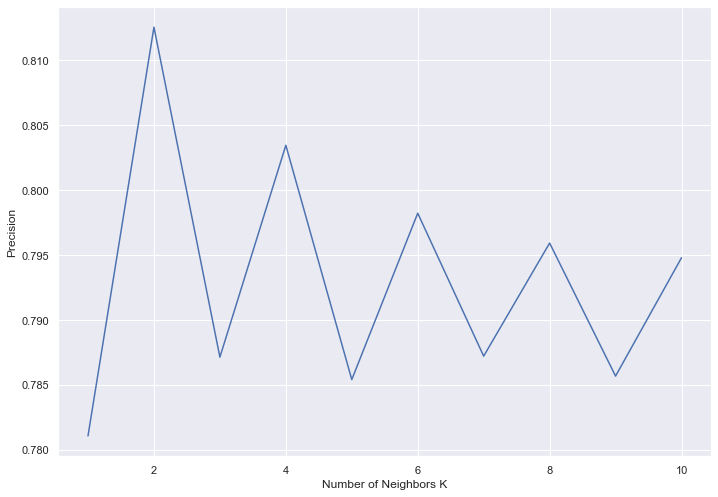

In [15]:
best_k = optimize_precision(X_train, y_train)

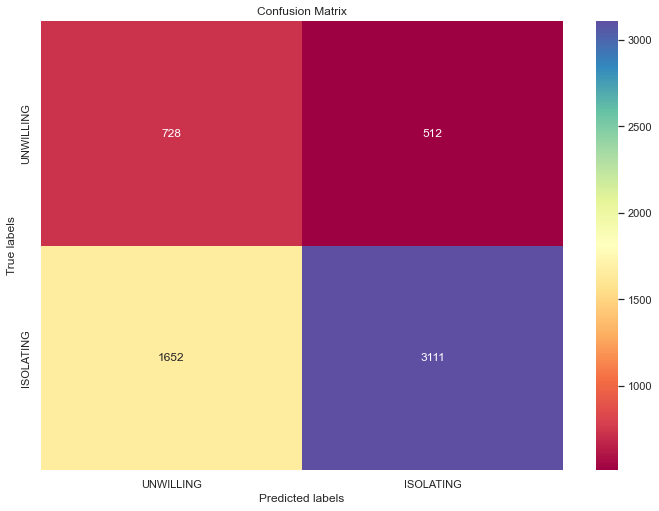

In [16]:
y_pred = plot_conf_matrix(X_train, y_train, X_test, y_test, best_k)

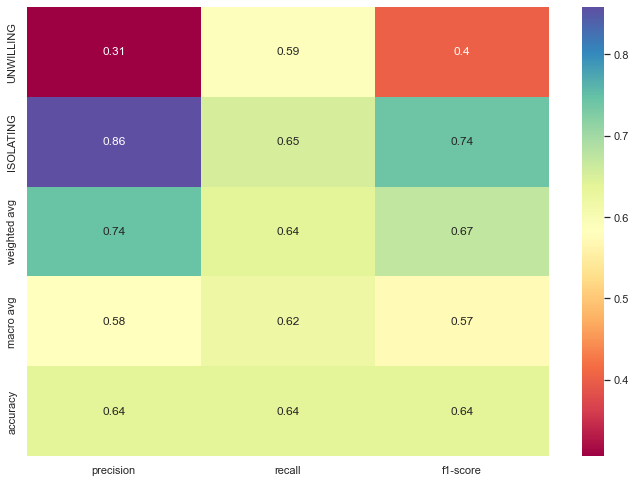

In [17]:
plot_report(y_test, y_pred)